<a href="https://colab.research.google.com/github/daffaiklildzakwan/APMKelompok6/blob/main/svm_nonlinear_kernel_rbf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [28]:
import os
os.environ['KAGGLE_CONFIG_DIR']='/content/gdrive/My Drive/kaggle'

In [40]:
!kaggle competition download -c flower-recognition-with-transfer-learning-and-svm

usage: kaggle [-h] [-v] {competitions,c,datasets,d,kernels,k,config} ...
kaggle: error: argument command: invalid choice: 'competition' (choose from 'competitions', 'c', 'datasets', 'd', 'kernels', 'k', 'config')


In [34]:
!ls

flower-recognition-with-transfer-learning-and-svm.log  gdrive  sample_data


In [35]:
import os

import numpy as np
import pandas as pd

import seaborn as sea

import tensorflow as tf
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import l2

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import OneHotEncoder
from sklearn.utils import shuffle
from sklearn import svm

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

In [36]:
sea.set_style("darkgrid")

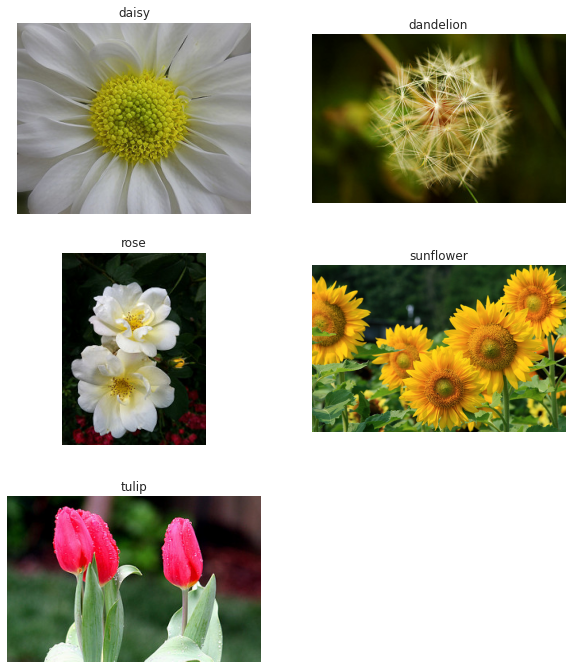

In [ ]:
classes = ["daisy", "dandelion", "rose", "sunflower", "tulip"]
path = "/kaggle/input/flowers-recognition/flowers"

file_path = [os.path.join(path, "daisy/100080576_f52e8ee070_n.jpg"),
             os.path.join(path, "dandelion/10043234166_e6dd915111_n.jpg"),
             os.path.join(path, "rose/10090824183_d02c613f10_m.jpg"),
             os.path.join(path, "sunflower/1008566138_6927679c8a.jpg"),
             os.path.join(path, "tulip/100930342_92e8746431_n.jpg")]

fig = plt.figure(figsize=(10, 12))
gs = gridspec.GridSpec(nrows=3, ncols=2, figure=fig)

for i in range(5):
    y, x = i//2, i%2 
    ax = fig.add_subplot(gs[y,x])
    ax.imshow(image.load_img(file_path[i]))
    ax.axis("off")
    ax.title.set_text(classes[i])

In [ ]:
# load pretrained MobileNet
model = MobileNet(input_shape=(224,224,3), include_top=True)

model.summary()

17227776/17225924 [==============================] - 1s 0us/step
Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________

In [ ]:
vector = model.get_layer("reshape_2").output
feature_extractor = tf.keras.Model(model.input, vector)

In [ ]:
# create empty feature and label lists
X_list = []
Y_list = []

for f in range(5):    
    folder_path = os.path.join(path, classes[f])
    for file in os.listdir(folder_path):    
        file_path = os.path.join(folder_path, file)
        
        # check file extension, skip file if not jpg
        if not(file.endswith(".jpg")):
            continue
        
        # load image
        img = image.load_img(file_path, target_size=(224,224))
        # convert image to numpy array
        img_arr = image.img_to_array(img)
        # add 1 more dimension
        img_arr_b = np.expand_dims(img_arr, axis=0)
        # preprocess image
        input_img = preprocess_input(img_arr_b)
        # extract feature
        feature_vec = feature_extractor.predict(input_img)
    
        X_list.append(feature_vec.ravel())
        Y_list.append(f)

In [ ]:
X = np.asarray(X_list, dtype=np.float32)
Y = np.asarray(Y_list, dtype=np.float32)

for s in range(100):
    X, Y = shuffle(X, Y)
    
print("Shape of feature matrix X")
print(X.shape)
print("\nShape of label matrix Y")
print(Y.shape)

class_types, counts = np.unique(Y, return_counts=True)

print("\nClass labels")
print(class_types)
print("\nClass counts")
print(counts)

Shape of feature matrix X
(4323, 1000)

Shape of label matrix Y
(4323,)

Class labels
[0. 1. 2. 3. 4.]

Class counts
[ 769 1052  784  734  984]


In [ ]:
train_X, test_X, train_Y, test_Y = train_test_split(X, Y, test_size=0.2,
                                                    stratify=Y,
                                                    random_state=0)

print("Shape of train_X")
print(train_X.shape)
print("\nShape of test_X")
print(test_X.shape)

Shape of train_X
(3458, 1000)

Shape of test_X
(865, 1000)


In [ ]:
svm_nlin = svm.SVC(C=1.0, kernel="rbf")
svm_nlin.fit(train_X, train_Y)
y_pred = svm_nlin.predict(test_X)
print(classification_report(test_Y, y_pred,
                            target_names=classes))

              precision    recall  f1-score   support

       daisy       0.94      0.89      0.91       154
   dandelion       0.92      0.93      0.92       210
        rose       0.86      0.89      0.87       157
   sunflower       0.95      0.94      0.94       147
       tulip       0.89      0.89      0.89       197

    accuracy                           0.91       865
   macro avg       0.91      0.91      0.91       865
weighted avg       0.91      0.91      0.91       865

